In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import metrics

import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

SEED = 1337

from transformers import AutoTokenizer, pipeline,BertTokenizer 
from bs4 import BeautifulSoup
!pip install contractions
import contractions
import string

from nltk.corpus import stopwords


C:\Users\jethr\anaconda3\envs\ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
print(cuda.is_available())

True


In [ ]:
PARENT_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
INPUT_DIR = os.path.join(PARENT_DIR,"data")
TRAIN_CSV = os.path.join(INPUT_DIR,"train.csv")
TEST_CSV = os.path.join(INPUT_DIR,"test.csv")
print(PARENT_DIR)
print(INPUT_DIR)

C:\Users\jethr\OneDrive\Documents\Kaggle
C:\Users\jethr\OneDrive\Documents\Kaggle\input


In [5]:
train_csv = pd.read_csv(TRAIN_CSV, dtype={'id': np.int16, 'target': np.int8})
test_csv = pd.read_csv(TEST_CSV, dtype={'id': np.int16})
df_train = pd.DataFrame(train_csv)
df_test = pd.DataFrame(test_csv)


print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


In [6]:
#understanding metadata
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

Referring to [Gunes Evitan's Notebook](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert) and [Rohit Gurad's Notebook](https://www.kaggle.com/code/rohitgarud/all-almost-data-preprocessing-techniques-for-nlp) on data cleaning & practice

In [7]:
#Set-up Lemmatization
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('stopwords')


def lemmatize_text(text):
    words = [lemmatizer.lemmatize(word) for word in text.split()]
    text = ' '.join(words)
    return text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jethr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jethr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
#set up word correction
!pip install symspellpy
import pkg_resources
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

True

In [9]:
def correct_spelling_symspell(text):
    words = [
        sym_spell.lookup(
            word, 
            Verbosity.CLOSEST, 
            max_edit_distance=2,
            include_unknown=True
            )[0].term 
        for word in text.split()] 
    text = " ".join(words)
    return text

In [10]:
#correctin compouund words
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

def correct_spelling_symspell_compound(text):
    words = [
        sym_spell.lookup_compound(
            word, 
            max_edit_distance=2
            )[0].term 
        for word in text.split()] 
    text = " ".join(words)
    return text

In [11]:
def clean_data(data):
    #fill NA
    data["keyword"] = data["keyword"].fillna("")
    data["location"] = data["location"].fillna("")
    #combine keyword with text
    data["tweet"] = data["keyword"] + " " + data["text"]
    #lower case
    data["tweet"] = data["tweet"].str.lower()
    #remove HTML
    data["tweet"] = data["tweet"].apply(lambda x: BeautifulSoup(x).get_text())
    #expand contractions
    data["tweet"] = data["tweet"].apply(contractions.fix)
    #remove URLs
    url_pattern = re.compile(r'https?://(www\.)?(\w+)(\.\w+)(/\w*)?')
    data["tweet"] = data["tweet"].apply(lambda x: re.sub(url_pattern,"",x))
    #remove emails
    email_pattern = re.compile(r"[\w\.-]+@[\w\.-]+\.\w+")
    data["tweet"] = data["tweet"].apply(lambda x: re.sub(email_pattern,"",x))
    #remove tweet mentions
    mention_pattern = re.compile(r"@\w+")
    data["tweet"] = data["tweet"].apply(lambda x: re.sub(mention_pattern,"",x))
    #remove punctuations, keeping hashtags to tokenize
    punc_clean = string.punctuation.replace("#","")
    data["tweet"] = data["tweet"].apply(lambda x: re.sub('[%s]' % re.escape(punc_clean), " ",x))
    #remove digits
    digit_pattern = re.compile("\w*\d+\w*")
    data["tweet"] = data["tweet"].apply(lambda x: re.sub(digit_pattern,"",x))  
    #remove extra space
    data["tweet"] = data["tweet"].apply(lambda x: re.sub(' +', ' ', x).strip())
    #lemmatize
    data["tweet"] = data["tweet"].apply(lemmatize_text)
    #clean spelling correction
    data["tweet"] = data["tweet"].apply(correct_spelling_symspell)
    #remove compound
    data["tweet"] = data["tweet"].apply(correct_spelling_symspell_compound)
    #remove stopwords
    stop_words = set(stopwords.words('english'))
    data["tweet"] = data["tweet"].apply(lambda x: " ".join([word for word in str(x).split() if word not in stop_words]))
    
    return data

In [12]:
#cleaning data
df_train = clean_data(df_train)
df_test = clean_data(df_test)

C:\Users\jethr\anaconda3\envs\ml\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\jethr\anaconda3\envs\ml\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [13]:
#Creating CustomDataset Class
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len,data_type):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.tweet = dataframe.tweet
        self.word_count = dataframe.word_count
        self.unique_word_count = dataframe.unique_word_count
        self.stop_word_count = dataframe.stop_word_count
        self.mean_word_length = dataframe.mean_word_length
        self.char_count = dataframe.char_count
        self.punctuation_count = dataframe.punctuation_count
        self.max_len = max_len
        self.data_type = data_type
        
        if data_type == "train":
            self.targets = dataframe.target
            self.data_type = data_type
        else:
            self.targets = ""
            self.data_type = "test"
        

    def __len__(self):
        return len(self.tweet)

    def __getitem__(self, index):
        tweet = str(self.tweet[index])
        tweet = " ".join(tweet.split())

        inputs = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        if self.data_type == "train":
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
                'targets': torch.tensor(self.targets[index], dtype=torch.float)
            }
        else:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
            }

In [14]:
#load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [79]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 100
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
EPOCHS = 10
LEARNING_RATE = 1e-05

# Creating the dataset and dataloader for the neural network
train_size = 0.8
train_dataset=df_train.sample(frac=train_size,random_state=200)
dev_dataset=df_train.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(df_train.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(dev_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN,"train")
testing_set = CustomDataset(dev_dataset, tokenizer, MAX_LEN,"train")

FULL Dataset: (7613, 15)
TRAIN Dataset: (6090, 15)
TEST Dataset: (1523, 15)


In [80]:
#Load in batch parameters
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [84]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased',return_dict=False)
        #self.l1 = BertForSequenceClassification.from_pretrained('bert-large-uncased',num_labels = 2,output_attentions = False,output_hidden_states = False)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 30)
        self.l4 = torch.nn.Linear(30,1)
        self.sigmoid = torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()
        torch.nn.init.xavier_uniform(self.l3.weight)
        torch.nn.init.xavier_uniform(self.l4.weight)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output_3 = self.l3(output_2)
        output_4 = self.relu(output_3)
        output_s = self.l4(output_4)
        output = self.sigmoid(output_s)
        return output
    

model = BERTClass()
model.to(torch.device('cuda:0')) 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\jethr\AppData\Local\Temp\ipykernel_24976\2462764309.py:13: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_unifor

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [85]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [86]:
#optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.SGD(params =  model.parameters(), lr=LEARNING_RATE, momentum=0.9)
optimizer = AdamW(model.parameters(),
                  lr = LEARNING_RATE, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )

In [87]:
torch.cuda.empty_cache()
train_history = {}

In [88]:
def train(epoch):
    batch = 0
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        
        loss = loss_fn(outputs[:,0], targets)
        if _%10==0:
            batch +=1
            train_history[batch] = loss.item()
            train_history[epoch] = loss.item()
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [89]:
torch.cuda.memory_allocated()

1764871680

In [90]:
#for training
torch.cuda.empty_cache()
for epoch in range(EPOCHS):
    train(epoch)


#Save PATH
PATH = r"C:\Users\jethr\OneDrive\Documents\Kaggle\NLPTweets\model.pt"

# for loading Saved model
#model = torch.load(PATH)
#model.load_state_dict(torch.load(PATH))
# Save trained model


C:\Users\jethr\anaconda3\envs\ml\lib\site-packages\transformers\tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Loss:  0.7203698754310608
Epoch: 0, Loss:  0.8127346038818359
Epoch: 0, Loss:  0.7164047956466675
Epoch: 0, Loss:  0.7067713141441345
Epoch: 0, Loss:  0.687717080116272
Epoch: 0, Loss:  0.7595506906509399
Epoch: 0, Loss:  0.5766982436180115
Epoch: 0, Loss:  0.6021121740341187
Epoch: 0, Loss:  0.6524345278739929
Epoch: 0, Loss:  0.7068862915039062
Epoch: 0, Loss:  0.668786883354187
Epoch: 0, Loss:  0.6812465190887451
Epoch: 0, Loss:  0.6420034170150757
Epoch: 0, Loss:  0.5425136089324951
Epoch: 0, Loss:  0.5363538861274719
Epoch: 0, Loss:  0.7015774250030518
Epoch: 0, Loss:  0.6270390152931213
Epoch: 0, Loss:  0.6577683687210083
Epoch: 0, Loss:  0.6740067005157471
Epoch: 0, Loss:  0.7094087600708008
Epoch: 0, Loss:  0.6855168342590332
Epoch: 0, Loss:  0.5982848405838013
Epoch: 0, Loss:  0.5922035574913025
Epoch: 0, Loss:  0.597419261932373
Epoch: 0, Loss:  0.618679404258728
Epoch: 0, Loss:  0.5827774405479431
Epoch: 0, Loss:  0.6250474452972412
Epoch: 0, Loss:  0.6017131209373

Epoch: 5, Loss:  0.5524152517318726
Epoch: 5, Loss:  0.623091459274292
Epoch: 5, Loss:  0.5507504940032959
Epoch: 5, Loss:  0.5300461053848267
Epoch: 5, Loss:  0.6408995985984802
Epoch: 6, Loss:  0.5301190614700317
Epoch: 6, Loss:  0.5032708644866943
Epoch: 6, Loss:  0.621981143951416
Epoch: 6, Loss:  0.5894856452941895
Epoch: 6, Loss:  0.6494957804679871
Epoch: 6, Loss:  0.6938496232032776
Epoch: 6, Loss:  0.6457271575927734
Epoch: 6, Loss:  0.6683382987976074
Epoch: 6, Loss:  0.637005090713501
Epoch: 6, Loss:  0.5507354140281677
Epoch: 6, Loss:  0.589728593826294
Epoch: 6, Loss:  0.698867917060852
Epoch: 6, Loss:  0.5271650552749634
Epoch: 6, Loss:  0.6585216522216797
Epoch: 6, Loss:  0.5984983444213867
Epoch: 6, Loss:  0.5926016569137573
Epoch: 6, Loss:  0.613937497138977
Epoch: 6, Loss:  0.5744919776916504
Epoch: 6, Loss:  0.6132736206054688
Epoch: 6, Loss:  0.6268442273139954
Epoch: 6, Loss:  0.6136600971221924
Epoch: 6, Loss:  0.7144628763198853
Epoch: 6, Loss:  0.660775780677795

In [91]:
def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [92]:
'''
for epoch in range(EPOCHS):
    outputs, targets = validation(epoch)
    outputs = np.array(outputs) >= 0.5
    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")
'''

'\nfor epoch in range(EPOCHS):\n    outputs, targets = validation(epoch)\n    outputs = np.array(outputs) >= 0.5\n    accuracy = metrics.accuracy_score(targets, outputs)\n    f1_score_micro = metrics.f1_score(targets, outputs, average=\'micro\')\n    f1_score_macro = metrics.f1_score(targets, outputs, average=\'macro\')\n    print(f"Accuracy Score = {accuracy}")\n    print(f"F1 Score (Micro) = {f1_score_micro}")\n    print(f"F1 Score (Macro) = {f1_score_macro}")\n'

In [93]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Save model
torch.save(model.state_dict(), PATH)

Model's state_dict:
l1.embeddings.position_ids 	 torch.Size([1, 512])
l1.embeddings.word_embeddings.weight 	 torch.Size([30522, 768])
l1.embeddings.position_embeddings.weight 	 torch.Size([512, 768])
l1.embeddings.token_type_embeddings.weight 	 torch.Size([2, 768])
l1.embeddings.LayerNorm.weight 	 torch.Size([768])
l1.embeddings.LayerNorm.bias 	 torch.Size([768])
l1.encoder.layer.0.attention.self.query.weight 	 torch.Size([768, 768])
l1.encoder.layer.0.attention.self.query.bias 	 torch.Size([768])
l1.encoder.layer.0.attention.self.key.weight 	 torch.Size([768, 768])
l1.encoder.layer.0.attention.self.key.bias 	 torch.Size([768])
l1.encoder.layer.0.attention.self.value.weight 	 torch.Size([768, 768])
l1.encoder.layer.0.attention.self.value.bias 	 torch.Size([768])
l1.encoder.layer.0.attention.output.dense.weight 	 torch.Size([768, 768])
l1.encoder.layer.0.attention.output.dense.bias 	 torch.Size([768])
l1.encoder.layer.0.attention.output.LayerNorm.weight 	 torch.Size([768])
l1.encoder.la

l1.encoder.layer.7.attention.self.value.bias 	 torch.Size([768])
l1.encoder.layer.7.attention.output.dense.weight 	 torch.Size([768, 768])
l1.encoder.layer.7.attention.output.dense.bias 	 torch.Size([768])
l1.encoder.layer.7.attention.output.LayerNorm.weight 	 torch.Size([768])
l1.encoder.layer.7.attention.output.LayerNorm.bias 	 torch.Size([768])
l1.encoder.layer.7.intermediate.dense.weight 	 torch.Size([3072, 768])
l1.encoder.layer.7.intermediate.dense.bias 	 torch.Size([3072])
l1.encoder.layer.7.output.dense.weight 	 torch.Size([768, 3072])
l1.encoder.layer.7.output.dense.bias 	 torch.Size([768])
l1.encoder.layer.7.output.LayerNorm.weight 	 torch.Size([768])
l1.encoder.layer.7.output.LayerNorm.bias 	 torch.Size([768])
l1.encoder.layer.8.attention.self.query.weight 	 torch.Size([768, 768])
l1.encoder.layer.8.attention.self.query.bias 	 torch.Size([768])
l1.encoder.layer.8.attention.self.key.weight 	 torch.Size([768, 768])
l1.encoder.layer.8.attention.self.key.bias 	 torch.Size([768])

In [94]:
# get prediction
def predict(test_dataset,tokenizer,max_len,model):
    tweet = str(test_dataset["tweet"])
    inputs = tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        max_length=max_len,
        pad_to_max_length=True,
        return_token_type_ids=True
    )
    
    #encode prediction dataset
    predict_ids = torch.tensor(inputs['input_ids'],dtype=torch.long)
    predict_mask = torch.tensor(inputs['attention_mask'],dtype=torch.long)
    predict_token_type_ids = torch.tensor(inputs["token_type_ids"],dtype=torch.long)
    
    print(predict_ids.shape)
    
    #forward pass
    outputs = model(predict_ids, predict_mask, predict_token_type_ids)
    
    return outputs    

In [95]:
eval_data = CustomDataset(df_test, tokenizer, MAX_LEN,"test")
eval_params = {'batch_size': 4,
                'shuffle': False,
                'num_workers': 0
                }
eval_loader = DataLoader(eval_data,**eval_params)
model.eval()
results = []
outputs = []
with torch.no_grad():
    for _,data in enumerate(eval_loader,0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)  
            outputs = model(ids, mask, token_type_ids).tolist()
            results.append(outputs)
        

In [96]:
flat_predictions = [item for sublist in results for item in sublist]
df_predict = pd.DataFrame(flat_predictions)

<AxesSubplot: ylabel='Count'>

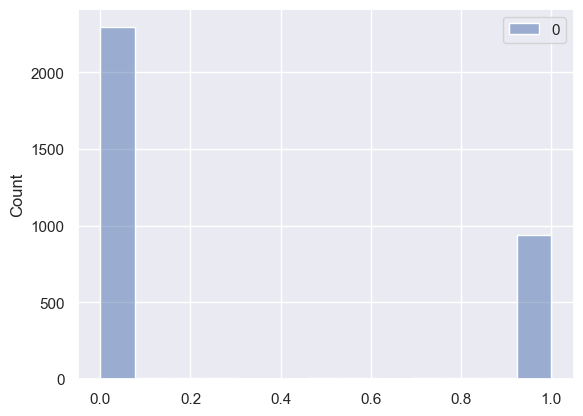

In [97]:
# check outputs
sns.set(style="darkgrid")
sns.histplot(df_predict)

In [98]:
# set threshold
df_predict[df_predict>=0.5] = int(1)
df_predict[df_predict< 0.5 ] = int(0)
df_predict[0].astype('int')

0       0
1       0
2       1
3       1
4       1
       ..
3258    1
3259    1
3260    1
3261    0
3262    1
Name: 0, Length: 3263, dtype: int32

In [99]:
# Creating submission data.

submission = pd.read_csv(r"C:\Users\jethr\OneDrive\Documents\Kaggle\NLPTweets\sample_submission.csv")
submission['target'] = df_predict[0].astype('int')
submission.dtypes


id        int64
target    int32
dtype: object

In [101]:
# Saving submission to '.csv' file:

submission.to_csv(r"C:\Users\jethr\OneDrive\Documents\Kaggle\NLPTweets\sample_submission2.csv", index=False, header=True)